# INF-0616 - Projeto 3: Redes neurais

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- a229999@dac.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina: 
[moodle.lab.ic.unicamp.br/469](https://moodle.lab.ic.unicamp.br/moodle/course/view.php?id=469)

Instituto de Computação - Unicamp 2022

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from joblib import parallel_backend

from IPython.display import display

In [2]:
rs = 12049
np.random.seed(12049)

plt.rcParams['figure.figsize'] = (12, 6)

#### Lendo o conjunto de dados

O conjunto de dados consiste em reclamações de clientes a cerca de produtos/serviços oferecidos em uma instituição bancária. ***Garanta que o arquivo*** `customer-issues.csv` ***está no mesmo diretório do notebook***.

In [3]:
d = pd.read_csv('./customer-issues.csv')
display(d.head())

,date-received,product,sub-product,issue,sub-issue,consumer-message,state,zip-code,tags,via,resolution,timely-response?,disputed?,complaint-id
0,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,AL,352XX,NaN,Web,Closed with explanation,Yes,No,2141773
1,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,PA,177XX,Older American,Web,Closed with explanation,Yes,No,2163100
2,6/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,VA,224XX,NaN,Web,Closed with explanation,Yes,No,1420702
3,2/3/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,TX,752XX,NaN,Web,Closed with explanation,Yes,Yes,1772196
4,2/17/2016,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,NE,693XX,NaN,Web,Closed with explanation,Yes,Yes,1790634


##### Exibindo as quatro primeiras mensagens

In [4]:
print(*d.loc[:4, 'consumer-message'], sep='\n\n')

I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements

I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had b

##### Extraíndo um conjunto de testes válido

As mensagens contidas neste conjunto possuem uma relação temporal.
É importante realizar a separação dos sub-conjuntos de treino/teste respeitando esta relação, de forma a garantir que o modelo não seja treinado sobre amostras no futuro e experimentado sobre o passado.

In [5]:
d.sort_values(by='date-received', inplace=True)

### Modelando a classificação de tópicos baseado nas mensagens de clientes

Observando no gráfico de frequências de produto sobre as conversas que este é um problema extremamente desbalanceado. Há, entretanto, amostras suficientes para a modelagem de um estimador de tópico (de produto) levando em consideração o diálogo do cliente.

In [6]:
def frequencies(dataset, column):
    labels, counts = np.unique(dataset[column], return_counts=True)
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]
    
    (sns
     .barplot([l[:40] for l in labels], counts)
     .set_title(f'Occurrences for The {len(labels)} Classes in {column}'))
    plt.xticks(rotation=90)
    
    return labels, counts

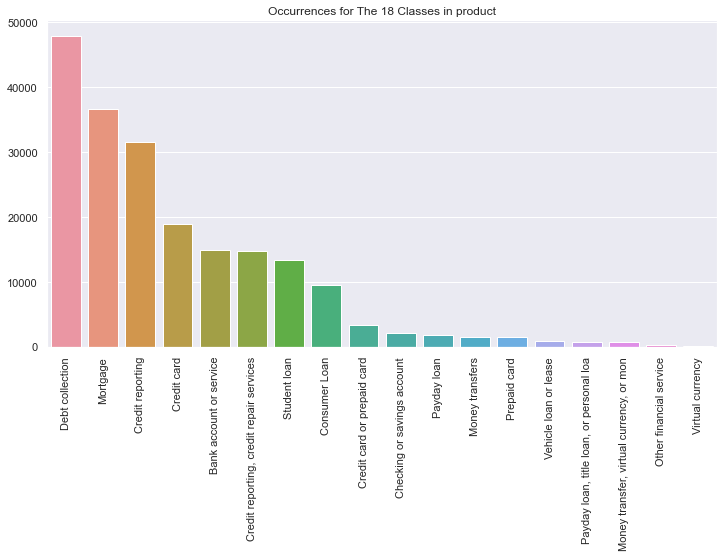

In [7]:
labels, counamts = frequencies(d, 'product')

Simplificamos o problema, considerando somente as 6 classes mais frequentes:

In [8]:
s = d['product'].isin(labels[:6])
d = d[s]

test_share = .3

d_train, d_test = train_test_split(d, test_size=test_share, shuffle=False)
assert d_train['date-received'].max() <= d_test['date-received'].min()

x_train, x_test = d_train['consumer-message'], d_test['consumer-message']
y_train, y_test = d_train['product'], d_test['product']

Vamos codificar as palavras na conversa utilizando o TF-IDF, gerando um vetor de características baseadas nas frequências de ocorrência das palavras no documento e em todo o conjunto de dados.

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

features = 1024

encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',
                                        max_features=features),
                        StandardScaler(with_mean=False))

x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)

label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_test = label_enc.transform(y_test)

## Treinando um regressor logístico para classificar produto
**Atividade (1 pt):** treine um regressor logístico, buscando os hiper-parâmetros com *grid-search*.

In [12]:
print(x_train.todense()[5].shape)

# Creating hyperparameters
penalty_range = ["l2", "l1"]
solver_range = ["saga"]
c_range = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
param_grid = dict(C=c_range, solver=solver_range, penalty=penalty_range)
cv = KFold(n_splits=3, shuffle=True, random_state=rs)

# Creating model and applying grid search to train model

lr = GridSearchCV(
    estimator=LogisticRegression(max_iter = 350), 
    param_grid=param_grid,
     cv=cv,
     scoring="accuracy",
      verbose=10)
with parallel_backend('threading', n_jobs=2):
    lr.fit(X=x_train, y=ye_train)
    


(1, 1024)
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=0.001, penalty=l2, solver=saga ................................[CV] C=0.001, penalty=l2, solver=saga ................................



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.0min


[CV] .... C=0.001, penalty=l2, solver=saga, score=0.830, total= 1.0min
[CV] C=0.001, penalty=l2, solver=saga ................................
[CV] .... C=0.001, penalty=l2, solver=saga, score=0.829, total= 1.0min
[CV] C=0.001, penalty=l1, solver=saga ................................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .... C=0.001, penalty=l2, solver=saga, score=0.827, total= 1.1min
[CV] C=0.001, penalty=l1, solver=saga ................................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.8min


[CV] .... C=0.001, penalty=l1, solver=saga, score=0.790, total= 1.8min
[CV] C=0.001, penalty=l1, solver=saga ................................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .... C=0.001, penalty=l1, solver=saga, score=0.790, total= 1.8min
[CV] C=0.01, penalty=l2, solver=saga .................................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .... C=0.001, penalty=l1, solver=saga, score=0.789, total= 1.9min
[CV] C=0.01, penalty=l2, solver=saga .................................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ..... C=0.01, penalty=l2, solver=saga, score=0.830, total= 1.1min
[CV] C=0.01, penalty=l2, solver=saga .................................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ..... C=0.01, penalty=l2, solver=saga, score=0.827, total= 1.1min
[CV] C=0.01, penalty=l1, solver=saga .................................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  6.1min


[CV] ..... C=0.01, penalty=l2, solver=saga, score=0.829, total= 1.0min
[CV] C=0.01, penalty=l1, solver=saga .................................


Iremos calcular a matriz de confusão relativa $R$, que guarda porcentagens de incidências em vez das contagens absolutas, e plotar o heatmap dessa matriz. Além disso, iremos calcular a distribuição de confiança nas predições por classe (mais próximos de `1.0` --> mais confiante):

In [73]:
def evaluate(y, p, probabilities, labels=None):
    # Cálculo das métricas de acerto.
    print('Accuracy:', metrics.accuracy_score(y, p).round(3))
    print('Accuracy (balanced):', metrics.balanced_accuracy_score(y, p).round(3))
    
    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)
    
    # Impressão dos gráficos.
    (plt
     .figure(figsize=(16, 12))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)

    (plt
     .figure(figsize=(16, 12))
     .suptitle('Distribuição de confiança para cada classe', fontsize=20))
    
    for i in np.unique(y):
        # Para cada classe `i`, seleciona suas amostras e filtra a confiança
        # do modelo em predizer estas amostras como sendo da classe `i`.
        sns.distplot(probabilities[y.ravel() == i][:, i],
                     hist=False,
                     label=labels[i])

Vamos utilizar a função `evaluate` para avaliar o modelo treinado anteriormente:

In [ ]:
evaluate(ye_test, lr.predict(x_test), lr.predict_proba(x_test), labels=label_enc.classes_)

**Pergunta (1pt):** considerando o gráfico de distribuição de confiança para o seu modelo treinado, as amostras são classificadas com alta confiança? Há uma grande diferença de confiança entre as diferentes classes?

----------
----------

## Redes Neurais
Iremos treinar alguns modelos de redes neurais, variando número de camadas e quantidade de neurônios em cada camada.

In [64]:
epochs = 20
batch_size = 128
input_shape = [features]

Vamos converter os rótulos em vetores *One Hot Encoded*:

In [65]:
from keras.utils import np_utils
y_ohe_train = np_utils.to_categorical(ye_train, num_classes=6)
y_ohe_test = np_utils.to_categorical(ye_test, num_classes=6)

**Atividade (1 pt):** defina uma arquitetura de uma rede neural capaz de classificar os diferentes produtos a partir da conversa dos clientes. Compile a sua rede com a loss `categorical_crossentropy`, optimizador `SGD` e defina as métricas relevantes para o problema. 

In [66]:
from keras import Sequential
from keras.layers import InputLayer, Dense

model = Sequential([
    InputLayer((1024,)),
    Dense(512, activation="relu"),
    Dense(100, activation="relu"),
    Dense(6, activation="sigmoid")
])

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [67]:
model.summary()
input_shape

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 512)               524800    
                                                                 
 dense_22 (Dense)            (None, 100)               51300     
                                                                 
 dense_23 (Dense)            (None, 6)                 606       
                                                                 
Total params: 576,706
Trainable params: 576,706
Non-trainable params: 0
_________________________________________________________________


[1024]

### Treinando a rede neural

**Atividade (1 pt):** treine o modelo definido acima sobre o conjunto, respeitando as seguintes regras:

1. Separe um subconjunto do treino para validação.
2. Utilize alguma técnica para conservar os parâmetros que melhor generalizam o problema, como `ModelCheckpoint` (salve o modelo com nome de `weights.h5`).

In [68]:
import tensorflow as tf
from keras import callbacks

In [69]:
device = '/gpu:0'  # ou '/gpu:0'

# Training model with validation split of .25
val_split = .25
with tf.device(device):
    model.fit(x_train.toarray(), y_ohe_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_split=val_split,
              verbose=1,
              callbacks=[
                  callbacks.TerminateOnNaN(),
                  callbacks.ModelCheckpoint('weights.h5',
                                            save_best_only=True,
                                            verbose=1),
              ])

Epoch 1/20
671/675 [============================>.] - ETA: 0s - loss: 0.8219 - categorical_accuracy: 0.7202
Epoch 1: val_loss improved from inf to 1.17693, saving model to weights.h5
675/675 [==============================] - 10s 10ms/step - loss: 0.8201 - categorical_accuracy: 0.7208 - val_loss: 1.1769 - val_categorical_accuracy: 0.6644
Epoch 2/20
672/675 [============================>.] - ETA: 0s - loss: 0.5057 - categorical_accuracy: 0.8391
Epoch 2: val_loss improved from 1.17693 to 1.08226, saving model to weights.h5
675/675 [==============================] - 6s 9ms/step - loss: 0.5058 - categorical_accuracy: 0.8390 - val_loss: 1.0823 - val_categorical_accuracy: 0.6832
Epoch 3/20
668/675 [============================>.] - ETA: 0s - loss: 0.4454 - categorical_accuracy: 0.8577
Epoch 3: val_loss improved from 1.08226 to 1.05357, saving model to weights.h5
675/675 [==============================] - 5s 7ms/step - loss: 0.4452 - categorical_accuracy: 0.8577 - val_loss: 1.0536 - val_categ

In [70]:
model.load_weights('weights.h5')

O método `model.fit` retorna `model.history`, e contem algumas informações interessantes a respeito do histórico de treinamento.

**Atividade (1 pt):** plote um gráfico de linhas exibindo a evolução dos valores da função *loss* sobre o conjunto de treino e validação. A partir de qual `epoch` a rede começou a super-especializar?

In [71]:
history_f = pd.DataFrame(model.history.history)
history_f

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,0.820137,0.720810,1.176927,0.664351
1,0.505849,0.839029,1.082257,0.683249
2,0.445186,0.857695,1.053569,0.692698
3,0.410201,0.868986,1.041935,0.694747
4,0.384085,0.877833,1.037986,0.695616
5,0.362396,0.884723,1.036416,0.696102
6,0.342853,0.890675,1.057590,0.695929
7,0.324939,0.896928,1.049852,0.699576
8,0.307748,0.903621,1.044308,0.700584
9,0.291215,0.909006,1.112246,0.697006


### Avaliando o modelo treinado

**Atividade (1 pt):** teste o modelo treinado utilizando o subconjunto de teste. Reporte a acurácia para cada classe e a matriz de confusão percentual (usando a função `evaluate` definida anteriormente).

1543/1543 [==============================] - 3s 2ms/step - loss: 0.9492 - categorical_accuracy: 0.7285
Test loss: 0.9491651654243469
Test accuracy (NOT BALANCED): 0.7284738421440125
1543/1543 [==============================] - 3s 2ms/step
Accuracy: 0.728
Accuracy (balanced): 0.705


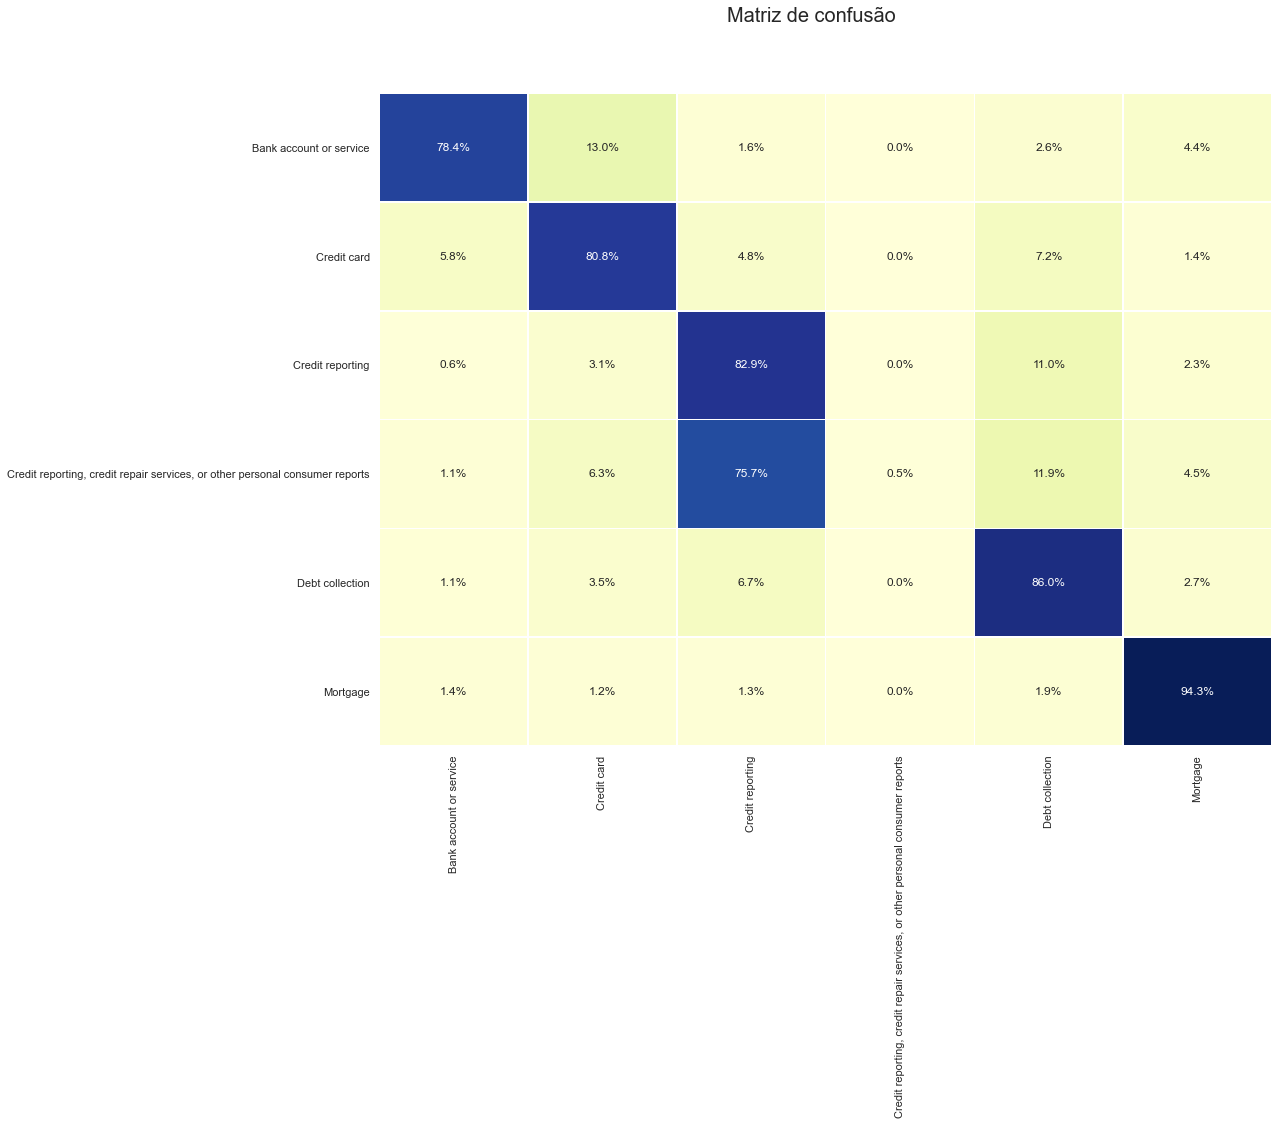

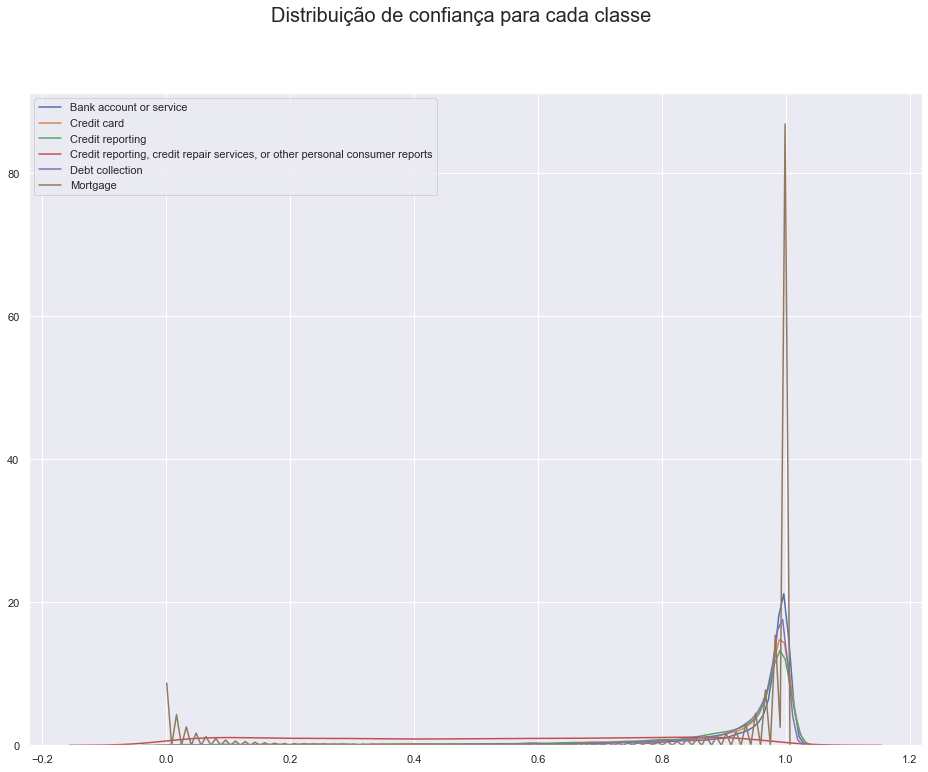

In [94]:
# Searching score
score = model.evaluate(x_test.toarray(), y_ohe_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy (NOT BALANCED):', score[1])

# Applying previously calculated function
probs = model.predict(x_test.toarray())
predicted_classes = np.argmax(probs, axis=-1)


evaluate(ye_test, predicted_classes, probs, labels=label_enc.classes_)


--------

Repita agora a definição, treinamento e avaliação de uma rede neural mais complexa, aumentando o número de camadas ou a quantidade de neurônios nas camadas da rede anterior:

**Atividade (1 pt):** defina uma rede neural mais complexa e a compile com as mesmas configurações da rede anterior.

In [99]:


model_complex = Sequential([
    InputLayer((1024,)),
    Dense(800, activation="relu"),
    Dense(600, activation="relu"),
    Dense(400, activation="relu"),
    Dense(200, activation="relu"),
    Dense(100, activation="relu"),
    Dense(50, activation="relu"),
    Dense(6, activation="sigmoid")
])

model_complex.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'])

**Atividade (1 pt):** treine a nova rede.

In [100]:
# Training model with validation split
with tf.device(device):
    model_complex.fit(x_train.toarray(), y_ohe_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_split=val_split,
              verbose=1,
              callbacks=[
                  callbacks.TerminateOnNaN(),
                  callbacks.ModelCheckpoint('weights_complex.h5',
                                            save_best_only=True,
                                            verbose=1),
              ])

Epoch 1/20
673/675 [============================>.] - ETA: 0s - loss: 1.0000 - categorical_accuracy: 0.6377
Epoch 1: val_loss improved from inf to 1.10113, saving model to weights_complex.h5
675/675 [==============================] - 13s 14ms/step - loss: 0.9991 - categorical_accuracy: 0.6380 - val_loss: 1.1011 - val_categorical_accuracy: 0.6661
Epoch 2/20
674/675 [============================>.] - ETA: 0s - loss: 0.5065 - categorical_accuracy: 0.8350
Epoch 2: val_loss improved from 1.10113 to 1.07686, saving model to weights_complex.h5
675/675 [==============================] - 10s 14ms/step - loss: 0.5066 - categorical_accuracy: 0.8350 - val_loss: 1.0769 - val_categorical_accuracy: 0.6702
Epoch 3/20
671/675 [============================>.] - ETA: 0s - loss: 0.4283 - categorical_accuracy: 0.8622
Epoch 3: val_loss improved from 1.07686 to 1.02290, saving model to weights_complex.h5
675/675 [==============================] - 9s 14ms/step - loss: 0.4287 - categorical_accuracy: 0.8621 - v

In [101]:
# Loading from file
model_complex.load_weights('weights_complex.h5')

# Taking history
history_f_complex = pd.DataFrame(model_complex.history.history)
history_f_complex

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,0.999089,0.638026,1.101130,0.666122
1,0.506579,0.834999,1.076863,0.670152
2,0.428657,0.862073,1.022900,0.685958
3,0.384389,0.877694,1.036466,0.685854
4,0.349233,0.889111,1.086581,0.687487
5,0.317292,0.899858,1.051745,0.684569
6,0.285319,0.910986,1.024700,0.691308
7,0.254916,0.921906,1.047513,0.694678
8,0.223046,0.933393,1.188511,0.689780
9,0.192530,0.944162,1.166316,0.688772


1543/1543 [==============================] - 6s 3ms/step - loss: 0.9179 - categorical_accuracy: 0.7239
Test loss: 0.9491651654243469
Test accuracy (NOT BALANCED): 0.7284738421440125
1543/1543 [==============================] - 6s 3ms/step
Accuracy: 0.724
Accuracy (balanced): 0.696


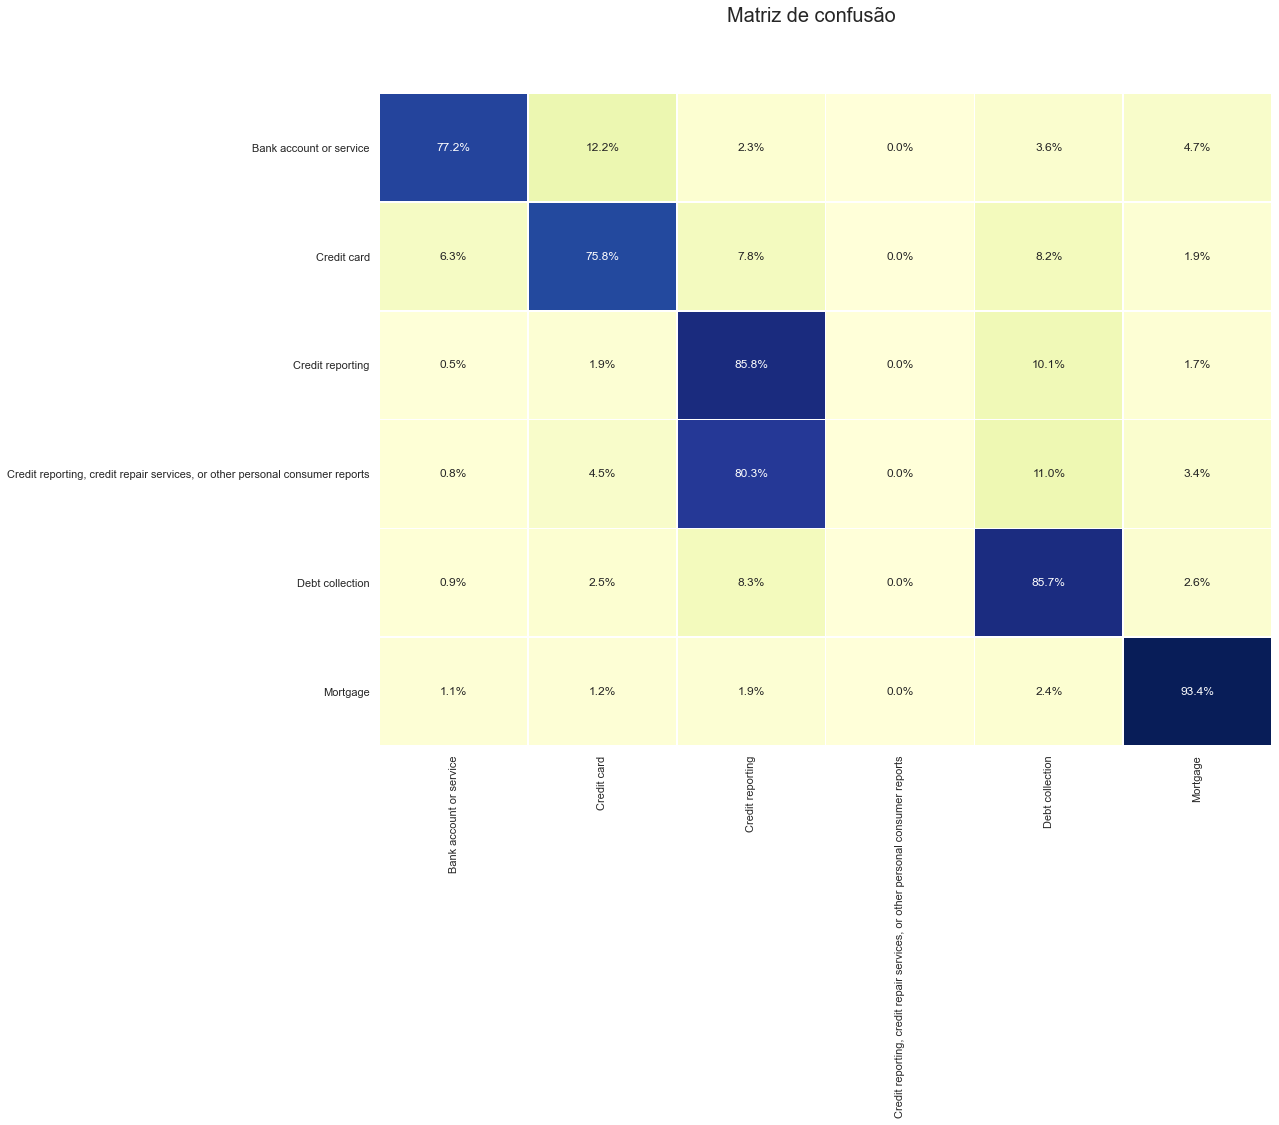

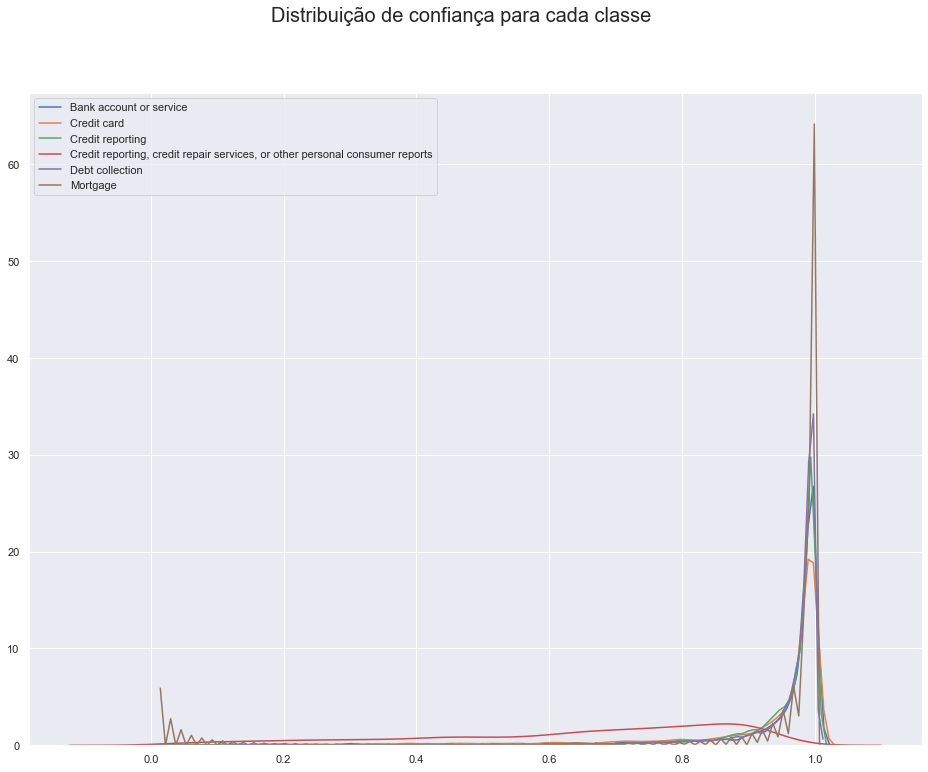

In [102]:
# Searching score
score_complex = model_complex.evaluate(x_test.toarray(), y_ohe_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy (NOT BALANCED):', score[1])

# Applying previously calculated function
probs_complex = model_complex.predict(x_test.toarray())
predicted_classes_complex = np.argmax(probs_complex, axis=-1)


evaluate(ye_test, predicted_classes_complex, probs_complex, labels=label_enc.classes_)

**Atividade (1 pt):** adicione dropout ou regularização L1/L2 e treine o novo modelo. Se for, preciso, faça uma busca pelos hipeparâmetros da regularização/dropout.

**Atividade (1 pt):** avalie os modelos treinados e compare com os resultados anteriores.